In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.linear_model import LinearRegression
import math

# Explore ArcticGRO data, clean, and write output for use elsewhere

Discharge data:
* Look at all discharge data. Gaps? If small, interpolate to get daily data for use in BEST-Siberian (to replace RADR data with)
* For two rivers, Kolyma and Pechora, have two sites with Q data. For these: merge into one time series by (a) deriving regression equation (if poss), (b) patching the key site with transformed values from the other site:
    * For **Kolyma**, the two discharge stations on the river are merged to make one series at Kolymskoe.
    * For **Pechora**. Oksino is the downstream station, but has much less monitoring data than Ust-Tsilma, further upstream. Area-scale Ust-Tsilma to get a patched series for Oksino.
* Truncate to period of interest (xxxx - 201x)
* Calculate monthly means.

Output: clean daily data, one site per river. Clean monthly data, one site per river.

# To do

Monthly series indexing - what do marine modellers do with monthly data? Retain daily datetime, or switch to just month? If daily, go for e.g. middle of the month? Currently have right closed values (so monthly mean for Jan is stored against 31st of Jan)
Same for RADR.

In [2]:
# User input

# Location of input data
in_q_folder = r'../../shared/pan_arctic_data/discharge/ArcticGRO/data/raw_download'

# Folders to save output
q_graph_folder = r'../../shared/pan_arctic_data/discharge/ArcticGRO/plots'
q_cleaned_daily_folder = r'../../shared/pan_arctic_data/discharge/ArcticGRO/data/cleaned_daily'
q_cleaned_monthly_folder = r'../../shared/pan_arctic_data/discharge/ArcticGRO/data/cleaned_monthly'

# Truncate data to these years (inclusive)
st_yr = 1980
end_yr = 2019

# Rivers with multiple sampling sites
multi_site_rivs = ['Pechora', 'Kolyma']

In [3]:
file_list = os.scandir(in_q_folder)
q_dict = {}  # Key: river name, returns df of Q
q_site_dict = {}  # Key: (river, site), returns df of Q for rivs with multiple sites
riv_list = []

# Read in raw Q data, truncate to desired time period, save in dict
for item in file_list:
    if item.is_file():  # Otherwise was getting ipython checkpoints too

        q_df = pd.read_excel(item,
                             usecols="E,F",
                             index_col=0,
                             parse_dates=True)

        q_df = q_df.loc['%s-01-01' % st_yr:'%s-12-31' % end_yr]

        riv_name = item.name.split('_')[0]
        samp_location = item.name.split('_')[1]

        # Make unique list of river names for later looping
        if riv_name not in riv_list:
            riv_list.append(riv_name)

        # Add Q data to dictionary, unless riv has multiple sampling sites.
        # In that case, it needs special treatment before it is added to dict (done below)
        if riv_name not in multi_site_rivs:
            q_dict[riv_name] = q_df
        else:
            q_site_dict[(riv_name, samp_location)] = q_df
        print("Finished reading in %s" %riv_name)

Finished reading in Onega
Finished reading in Pur
Finished reading in Kolyma
Finished reading in Yana
Finished reading in Lena
Finished reading in Nadym
Finished reading in Ob
Finished reading in Pechora
Finished reading in Yukon
Finished reading in Olenek
Finished reading in Mezen
Finished reading in Indigirka
Finished reading in Yenisei
Finished reading in Kolyma
Finished reading in Pechora
Finished reading in Mackenzie
Finished reading in NorthernDvina


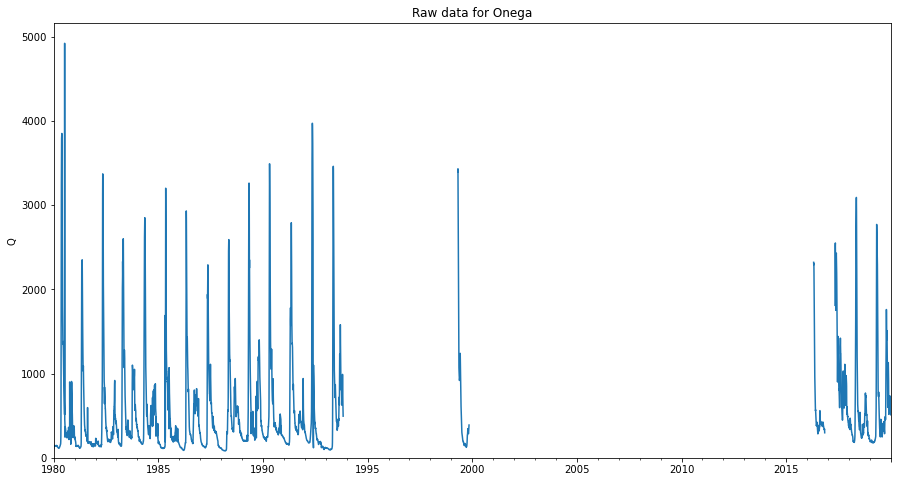

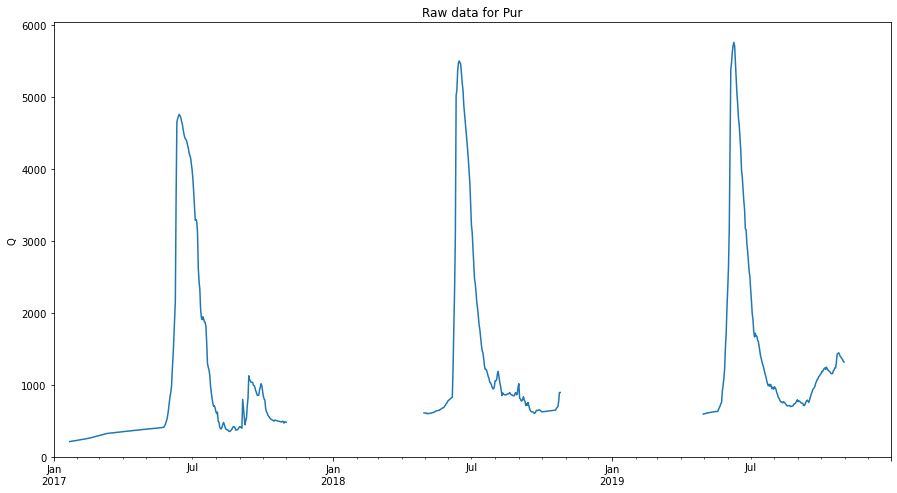

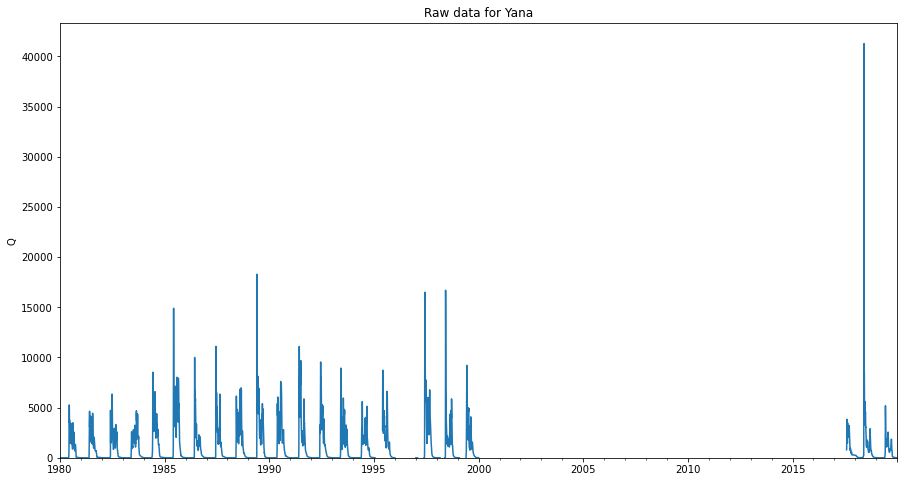

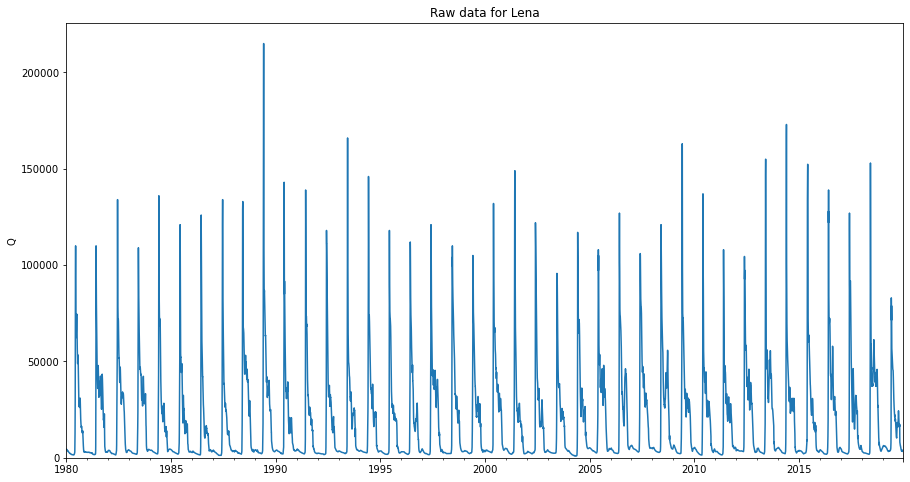

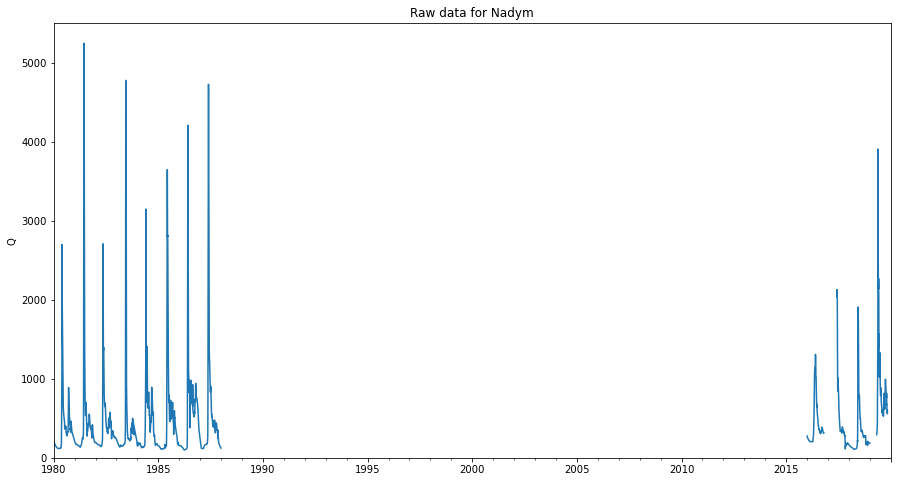

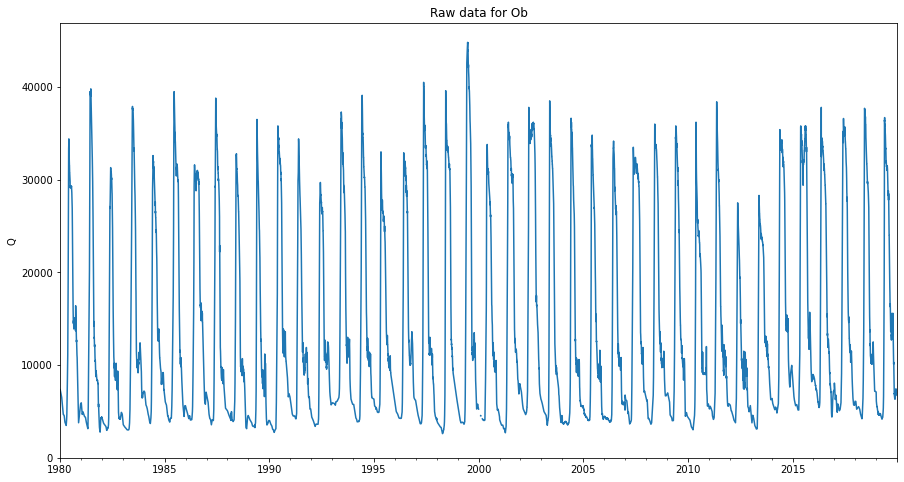

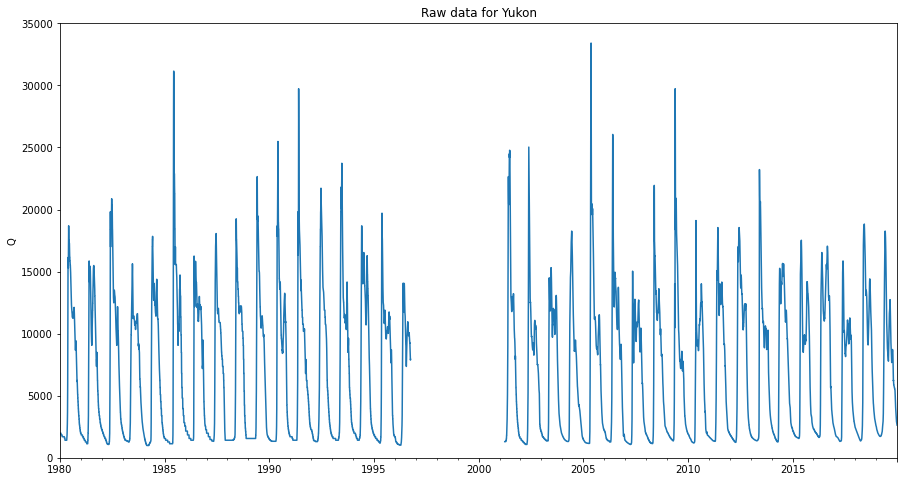

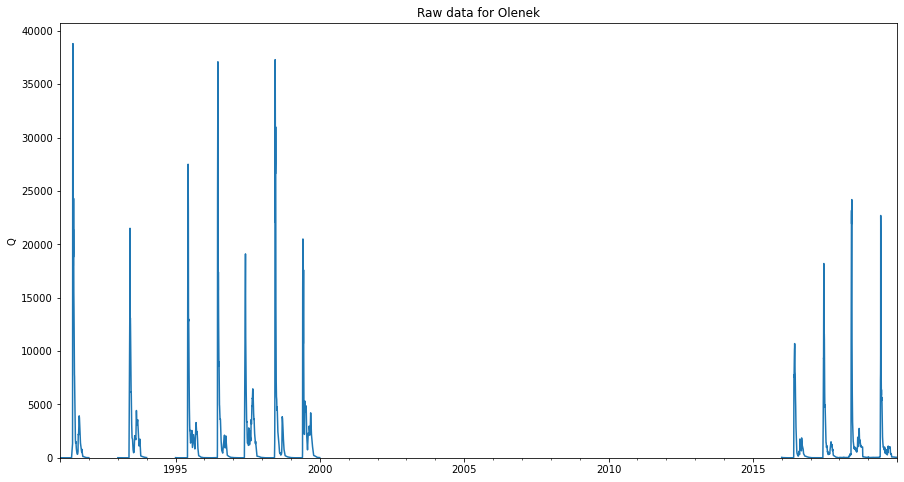

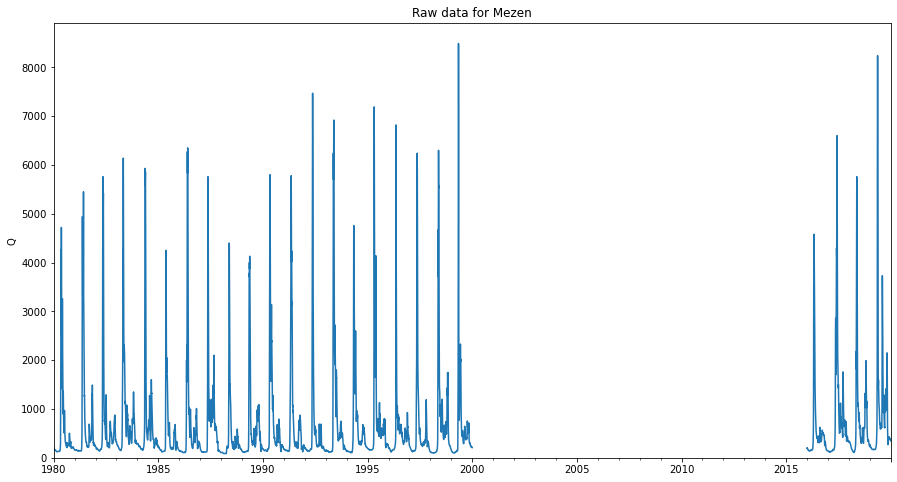

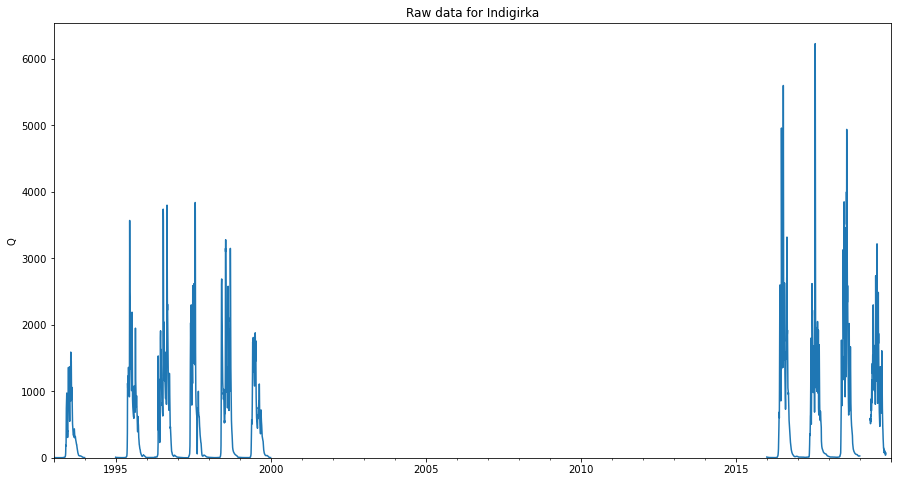

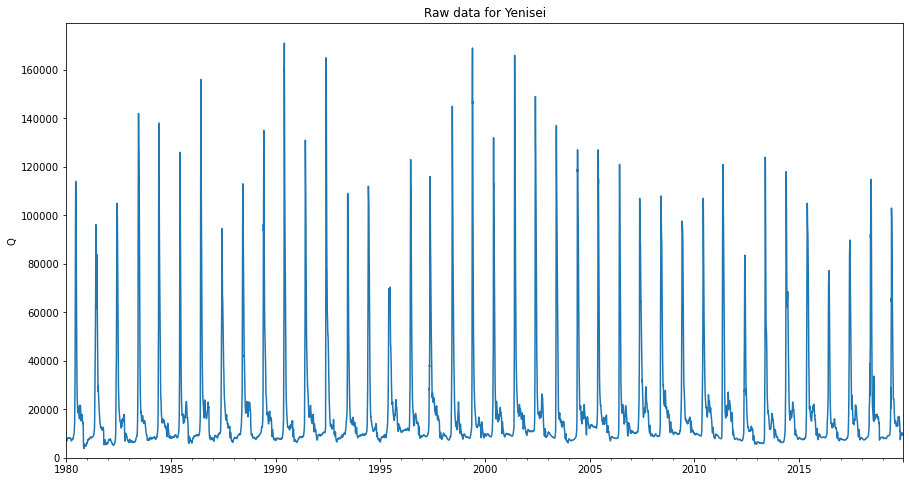

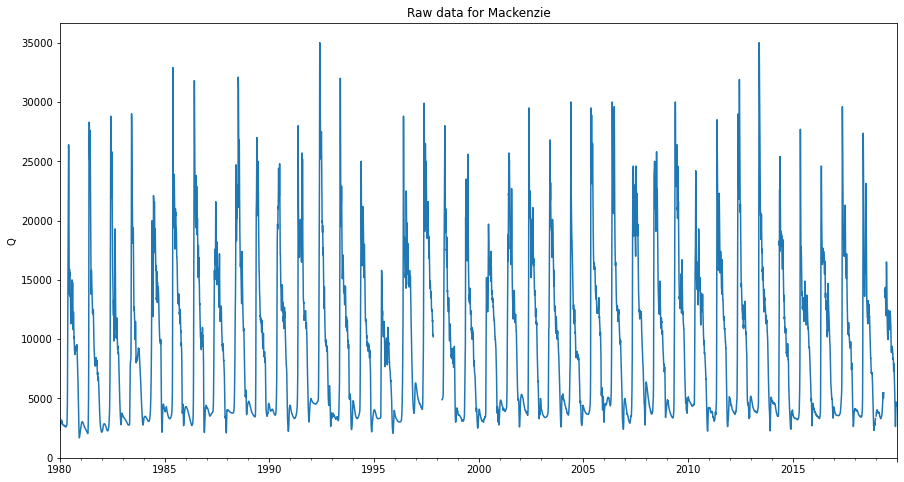

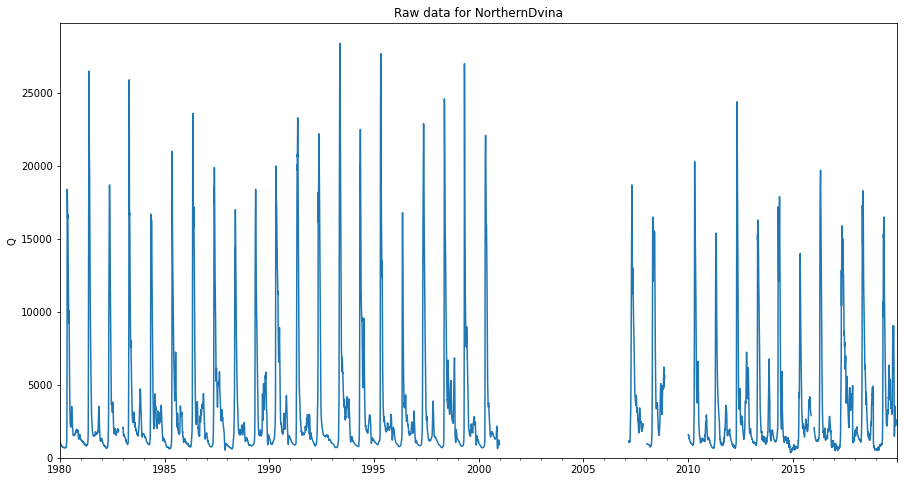

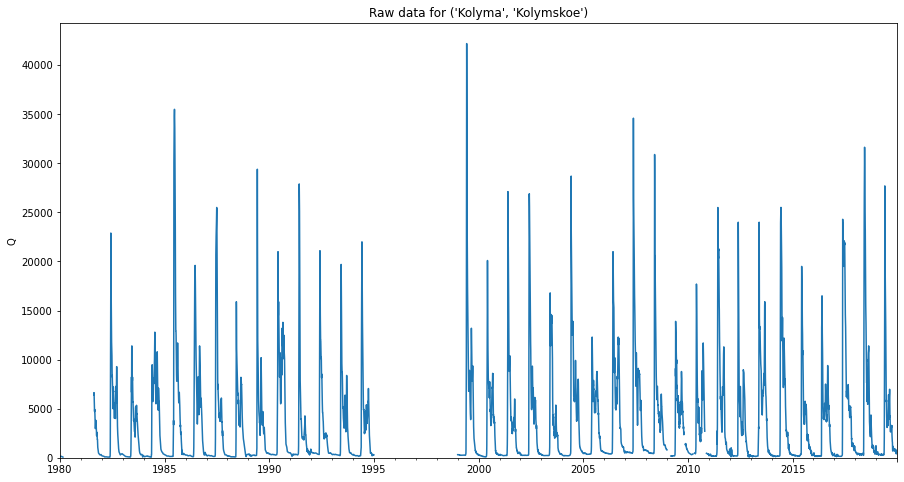

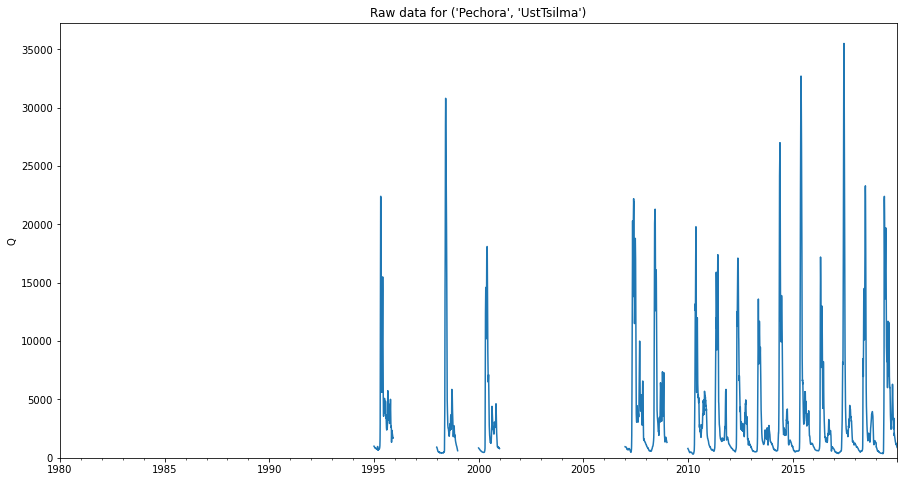

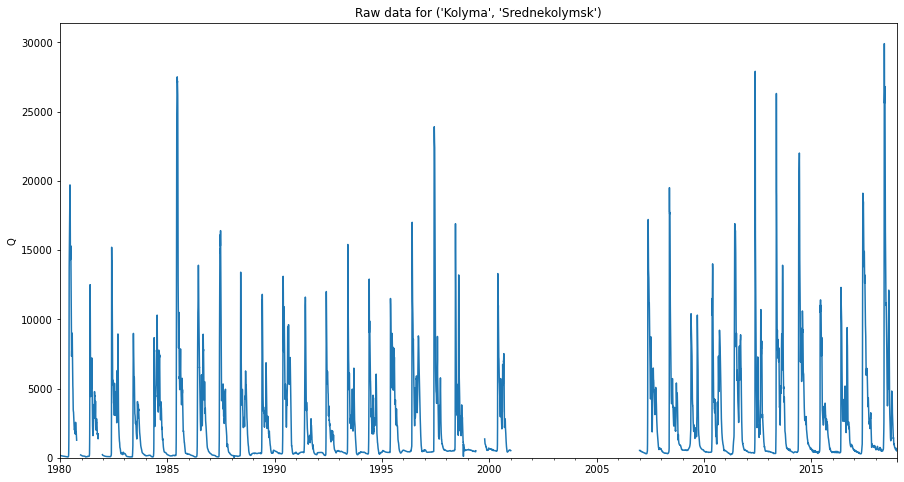

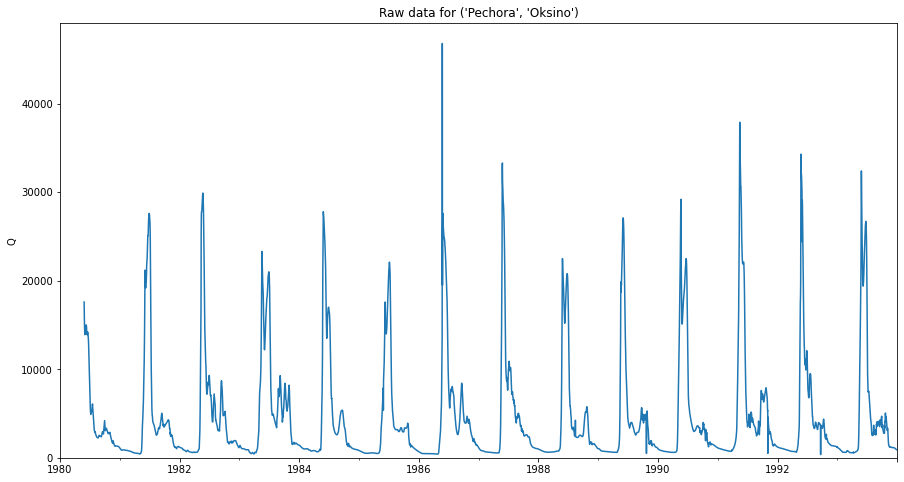

In [7]:
# Quick plot of Q data from each site
for site in list(q_dict.keys()) + list(q_site_dict.keys()):
    fig = plt.figure(figsize=(15, 8))
    ax = fig.add_subplot()
    if site in q_dict.keys():
        q_dict[site].plot(legend=False, ax=ax)
    else:
        q_site_dict[site].plot(legend=False, ax=ax)
    plt.ylim(ymin=0)
    plt.xlabel("")
    plt.ylabel("Q")
    plt.title("Raw data for %s" % str(site))
    plt.savefig(os.path.join(q_graph_folder,
                             'raw_data_%s-%s_%s' % (st_yr, end_yr, str(site))))

## QC issues: data cleaning
From a quick look, there's some clear data dodginess:
- Onega: Lots of artificial peaks and troughs before 1995. Clear errors when you zoom in. Have been through these in detail, and come up with a list that needs deleting.
- Mackenzie: artificial-looking drop and then rise in Q at the start of every winter, presumably as the river freezes. Should the rise happen, or is that just an artefact? Suspect the latter, as it's not seen in any of the other (presumably not that dissimilar?) rivers.
- Pechora (Oksino): dodgy drops at start of freezing from 1989


In [47]:
onega_del_dates = [
                   # '1979-06-09',
                   '1980-07-10',
                   '1980-02-29',
                   '1980-07-17',
                   '1980-10-06',
                   '1980-10-17',
                   '1980-10-25',
                   '1980-11-06',
                   '1980-11-17',
                   '1980-12-17',
                   '1980-12-26',
                   '1981-08-14',
                   '1982-05-09',
                   '1982-06-05',
                   '1983-02-01',
                   '1984-09-21',
                   '1984-10-21',
                   '1984-11-21',
                   '1984-12-21',
                   '1985-04-29',
                   '1985-04-30',
                   '1985-07-04',
                   '1985-08-04',
                   '1985-09-04',
                   '1985-10-04',
                   '1985-11-04',
                   '1985-12-04',
                   '1989-04-07',
                   '1989-05-07',
                   '1989-05-09',
                   '1989-06-07',
                   '1989-07-07',
                   '1989-08-07',
                   '1989-09-07',
                   '1990-10-14',
                   '1990-11-14',
                   '1992-05-25', '1992-05-26', '1992-05-27', '1992-05-28',
                   '1992-05-29', '1992-05-30', '1992-05-31']

In [61]:
onega_raw.head()

,discharge
date,
1980-01-01,114.0
1980-01-02,146.0
1980-01-03,148.0
1980-01-04,148.0
1980-01-05,149.0


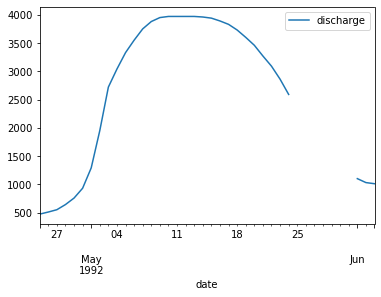

In [69]:
# Delete dodgy data from Onega
q_dict['Onega'].loc[onega_del_dates, 'discharge'] = np.nan

# Quick check
q_dict['Onega']['1992-04-25':'1992-06-03'].plot()

## Merge multiple gauging sites on the same river

In [8]:
def patch_series(series_to_patch, site_names, apply_time_lag,
                 d_between_points, areas=None):
    """
    Function to patch one series using another, using
    a linear regression between the two series if the two series have more than
    365 overlapping points. If not, area-scaling is used instead.
    Input:
    series_to_patch, a list of two series. The first should be the one that
    needs patching (y), the second is used to do the patching (x). Also assume
    the first is downstream of the second for now.
    site_names: list of site names associated with the two series
    apply_time_lag: boolean (True or False). Apply a time shift to the second
    series, to account for water travel time between the two sampling points?
    Assumes that the second series is upstream and water velocity of 0.8 m/s
    d_between_points: downstream distance between sampling points (km)
    areas: list with catchment areas associated with two series (km2). Only
    used if area scaling is used for patching instead of regression.
    """
    if apply_time_lag is True:
        # Expect discharge at downstream point (first series) to correspond to Q
        # at upstream point (second series) a few days previously. So shift second
        # series forward in time to match first series.
        day_lag = math.ceil(d_between_points * 1000 / (0.8 * 86400))  # 0.8 m/s, 3 km/hr
        print('day lag applied, series 2 shifted %s days forward' % day_lag)
        shifted_s = series_to_patch[1].shift(periods=day_lag)
        series_to_patch = [series_to_patch[0], shifted_s]

    joined_df = series_to_patch[0].join(series_to_patch[1],
                                        how='outer',
                                        lsuffix='_%s' % site_names[0],
                                        rsuffix='_%s' % site_names[1])

    # Plot of raw series
    joined_df.plot(figsize=(15, 7), title="Plot of raw series")
    plt.ylim(ymin=0);
    plt.show()

    # # Close up plot to check that temporal adjustment looks ok
    # joined_df.loc['1-11-2015':'31-10-2018'].plot(figsize=(18, 8),
    #                                              title="Plot of zoomed raw series")
    # plt.ylim(ymin=0);
    # plt.show()

    # Get ready to patch
    joined_df_no_nans = joined_df.dropna(axis=0)

    days_to_patch = np.array(joined_df[joined_df.iloc[:, 0].isnull()].index)
    x_new = joined_df.iloc[:, 1].loc[days_to_patch].dropna()
    days_to_patch = x_new.index  # Reset days_to_patch, excluding na values

    # Linear regression, if have at least a year of data overlap
    if len(joined_df_no_nans > 365):

        y = joined_df_no_nans.iloc[:, 0].values
        x = joined_df_no_nans.iloc[:, 1].values.reshape((-1, 1))

        model = LinearRegression().fit(x,y)
        y_pred = model.predict(x)

        r_sq = model.score(x,y)
        print('coefficient of determination:', r_sq)
        print('intercept:', model.intercept_)
        print('slope:', model.coef_)

        # Plot output of linear regression
        plt.scatter(x, y, color="black")
        plt.plot(x, y_pred, color="blue", linewidth=2)
        plt.xlabel(site_names[0])
        plt.ylabel(site_names[1])
        plt.show()

        # Predict values for gaps in the first series, using observations from the second series
        x_new = x_new.values.reshape((-1, 1))
        y_new = model.predict(x_new)
        s0_to_patch = pd.Series(index=days_to_patch, data=y_new)

    # If not enough overlapping data for a regression, apply area-scaling
    else:
        s0_to_patch = series_to_patch[1].dropna() * (areas[0]/areas[1])
        s0_to_patch = s0_to_patch.squeeze()  # Convert from df to series

    s0_to_patch.name = 'discharge'
    patched_series = joined_df.iloc[:, 0].combine_first(s0_to_patch)
    joined_df['patched'] = patched_series

    # Plot to check that patching has worked ok and looks sensible
    print('Number of days patched in the first series (x): %s' % len(days_to_patch))

    axs = joined_df.plot(figsize=(18, 8), subplots=True, sharex=True)
    for ax in axs:
        plt.ylim(ymin=0);
    plt.title("Raw and patched series")
    plt.show()

    return patched_series

day lag applied, series 2 shifted 5 days forward


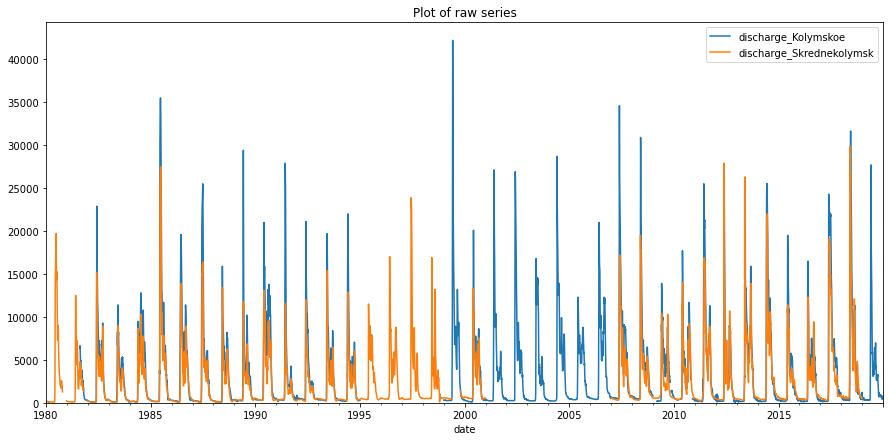

coefficient of determination: 0.8892823921456424
intercept: 92.89381780431722
slope: [1.29790053]


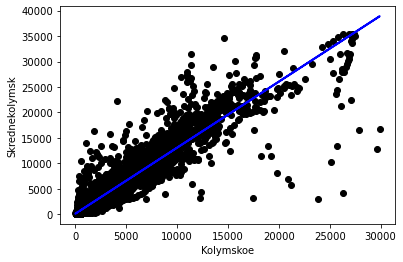

Number of days patched in the first series (x): 2129


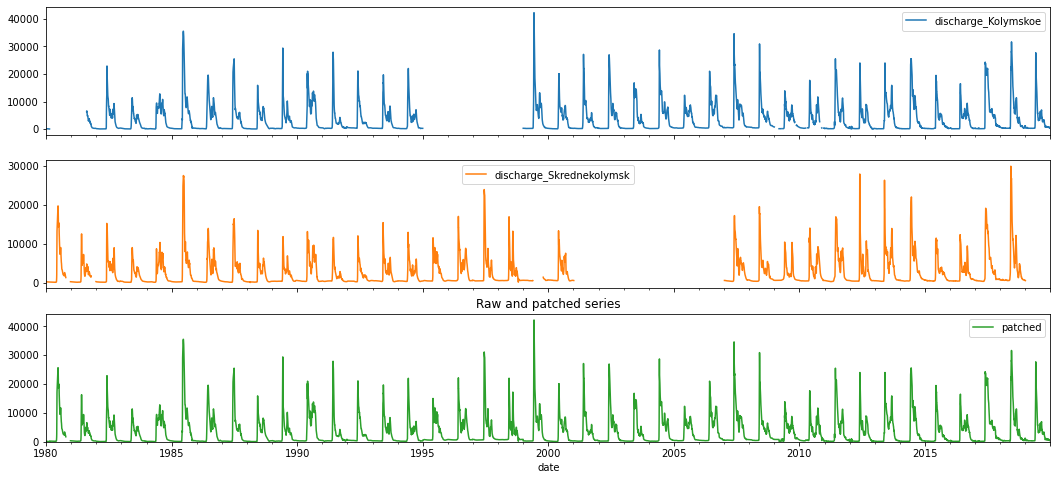

In [9]:
# Patch the two stations on the Kolyma river to make one series at Kolymskoe
s_to_join = [q_site_dict[('Kolyma', 'Kolymskoe')],
             q_site_dict[('Kolyma', 'Srednekolymsk')]]
s_names = ['Kolymskoe', 'Skrednekolymsk']
apply_time_lag = True
d_between_points = 320  # km

q_dict['Kolyma'] = patch_series(s_to_join, s_names, apply_time_lag, d_between_points).to_frame()

day lag applied, series 2 shifted 6 days forward


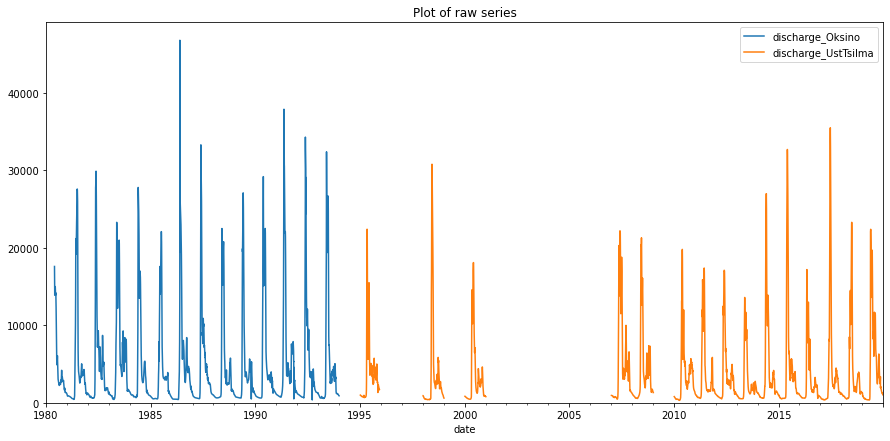

Number of days patched in the first series (x): 5442


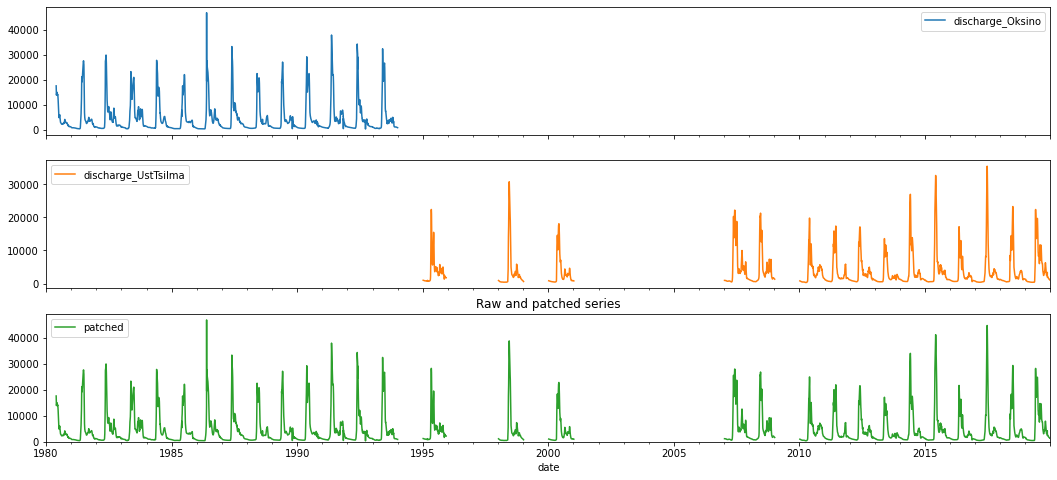

In [10]:
# Pechora river. Oksino is the downstream station, but has much less monitoring
# data than Ust-Tsilma. No overlapping data, so area-scale.
# Decide to area-scale Ust-Tsilma to get patched series for Oksino.

series_to_patch = [q_site_dict[('Pechora', 'Oksino')], q_site_dict[('Pechora', 'UstTsilma')]]
site_names = ['Oksino', 'UstTsilma']
apply_time_lag = True
d_between_points = 388  # km, according to https://www.compositerunoff.sr.unh.edu/html/Polygons/P6970650.html
areas = [312000, 248000]  # Oksino, Ust-Tsilma; km2

q_dict['Pechora'] = patch_series(series_to_patch, site_names, apply_time_lag, d_between_points, areas).to_frame()

## Interpolate to fill short gaps

In [70]:
nan_limit = 75  # 75 ok for Kolyma
q_interp_dict = {}  # Key: river name, returns dict of Q with short gaps filled

for river in q_dict.keys():
    data = q_dict[river]
    mask = data.copy()
    grp = ((mask.notnull() != mask.shift().notnull()).cumsum())
    grp['ones'] = 1
    for i in data.columns:
        mask[i] = (grp.groupby(i)['ones'].transform('count') < nan_limit) | data[i].notnull()
    filled_series = data.interpolate(method='linear')[mask]
    q_interp_dict[river] = filled_series

    # Print out number of NaNs filled per river
    NaNs_start = int(q_dict[river].isna().sum())
    NaNs_end = int(filled_series.isna().sum())
    NaNs_filled = NaNs_start - NaNs_end
    print("%s: %s NaNs filled by interpolation" % (river, NaNs_filled))

Onega: 42 NaNs filled by interpolation
Pur: 61 NaNs filled by interpolation
Yana: 1 NaNs filled by interpolation
Lena: 0 NaNs filled by interpolation
Nadym: 57 NaNs filled by interpolation
Ob: 60 NaNs filled by interpolation
Yukon: 0 NaNs filled by interpolation
Olenek: 0 NaNs filled by interpolation
Mezen: 0 NaNs filled by interpolation
Indigirka: 56 NaNs filled by interpolation
Yenisei: 0 NaNs filled by interpolation
Mackenzie: 23 NaNs filled by interpolation
NorthernDvina: 192 NaNs filled by interpolation
Kolyma: 67 NaNs filled by interpolation
Pechora: 0 NaNs filled by interpolation


<AxesSubplot:xlabel='date'>

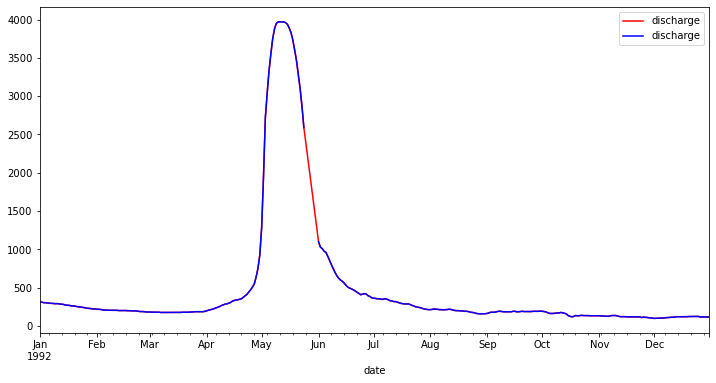

In [72]:
# Plot an example to check working ok
riv = 'Onega'
st = '1992'
end = '1992'
ax = plt.figure().add_subplot(111)
q_interp_dict[riv].loc[st:end].plot(color='r', figsize=(12,6), ax=ax)
q_dict[riv].loc[st:end].plot(color='b', ax=ax)

In [73]:
# # Future improvement would be to change the interpolation limit
# # according to the season (much longer if outside the melt season).
# # But not immediately obvious how to do, so leave for now.

# def season(x):
#     """Input month number, and return the season it corresponds to
#     """
#     if x in [9,10,11,12,1,2,3]:
#         return 'winter'
#     else:
#         return 'summer'

# limit_dict = {'winter': 120, 'summer': 30}

# cur_df['season'] = cur_df.index.month.map(season)

## Write cleaned data to csv

In [78]:
for riv in riv_list:
    q_dict[riv].to_csv(os.path.join(q_cleaned_daily_folder, '%s_daily_%s-%s.csv' % (riv, st_yr, end_yr)))

# Convert to monthly

In [99]:
q_monthly_dict = {}  # Key: river name, returns monthly mean Q

for riv in riv_list:
    # q_monthly_dict[riv] = q_dict[riv].resample('M').mean(min_count=20)
    daily_df = q_dict[riv]
    monthly_df = daily_df.resample('M').agg(np.mean)
    q_monthly_dict[riv] = monthly_df

<AxesSubplot:xlabel='date'>

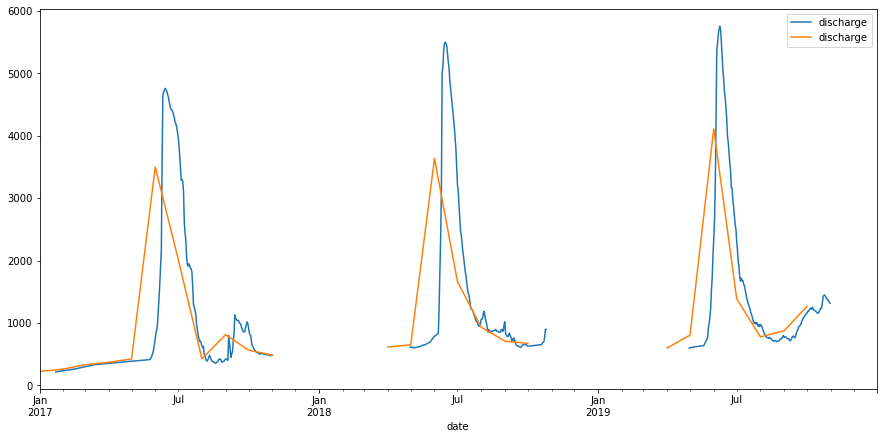

In [100]:
# Quick plot to check working ok
riv = 'Pur'
ax = plt.figure(figsize=(15,7)).add_subplot(111)
q_dict[riv].plot(ax=ax)
q_monthly_dict[riv].plot(ax=ax)

## Write monthly data to csv


In [101]:
for riv in riv_list:
    q_monthly_dict[riv].to_csv(os.path.join(q_cleaned_monthly_folder, '%s_monthly_%s-%s.csv' % (riv, st_yr, end_yr)))